In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
import xarray
import seaborn as sns
from scipy import stats

In [2]:
energy = pd.read_csv('Downloads/ARWF1.csv')
energy

,SETTLEMENTDATE,ARWF1
0,2016-06-23 00:05:00,0.0
1,2016-06-23 00:10:00,0.0
2,2016-06-23 00:15:00,0.0
3,2016-06-23 00:20:00,0.0
4,2016-06-23 00:25:00,0.0
...,...,...
581088,2021-12-31 23:35:00,9.4
581089,2021-12-31 23:40:00,9.8
581090,2021-12-31 23:45:00,9.9
581091,2021-12-31 23:50:00,12.3


Ararat coordinates: 37.24°S 142.98°E <br>
Ararat gridpoints: (11, 19)

In [3]:
energy.iloc[:,0] = pd.to_datetime(energy.iloc[:,0], infer_datetime_format = True)
energy_2018_bool = energy.SETTLEMENTDATE.dt.year == 2018
energy_2018 = energy[energy_2018_bool]
energy_night = ~((energy.SETTLEMENTDATE.dt.hour>=6) & (energy.SETTLEMENTDATE.dt.hour<18))
energy_2018_night = energy[energy_night & energy_2018_bool]
type(energy_2018_night.SETTLEMENTDATE.iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

Text(0.5, 1.0, 'Average half hourly energy produced Ararat Bridge Windfarm 2018')

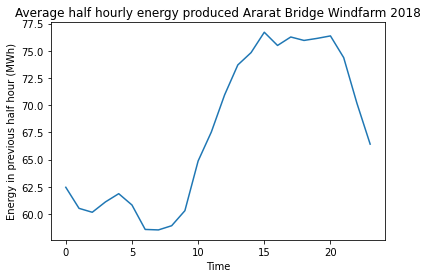

In [4]:
mean_hourly = energy_2018.groupby(energy_2018["SETTLEMENTDATE"].dt.hour).mean()
plt.plot(mean_hourly)
plt.xlabel('Time')
plt.ylabel('Energy in previous half hour (MWh)')
plt.title('Average half hourly energy produced Ararat Bridge Windfarm 2018')

In [19]:
gridpoints = 2 # number of gridpoints to analyse either side of centre gridpoint
jetnight = xarray.open_dataset('/g/data/v46/lh2344/jetnightsv3')
jetnight2 = xarray.DataArray(jetnight.jetnight2_v3, dims = ['time','latitude','longitude'])
jetnight2 = jetnight2.isel(latitude = slice(11-gridpoints,11+gridpoints), longitude = slice(19-gridpoints,19+gridpoints))
t = np.arange(datetime(2017,12,31,6,0,0), datetime(2018,12,31,6,0,0), timedelta(days=1)).astype(datetime)
jetnight2['time'] = t
jetnight2_2018 = jetnight2
jetnight_true = jetnight2_2018.sum(dim = ['latitude', 'longitude']) > 0
print(jetnight_true.sum().data)

45


In [20]:
# On a jetnight an array is created so that every 5 minute timestep within a jetnight is defined at 'True' and
# 'False' otherwise
jethour_true = np.empty(365*288)
for day in range(0,365):
    daystart = day*288
    dayend = (day*288)+288
    for hour in range(daystart,dayend):
        jethour_true[hour] = jetnight_true[day]
jethour_true.sum()
jethour_true = np.array(jethour_true, dtype = bool)

In [21]:
days = np.arange(datetime(2018,1,1), datetime(2019,1,1), timedelta(days=1)).astype(datetime)
jetnight_true1 = pd.DataFrame([days,jetnight_true.to_numpy()])#, columns = ['Day','Jetnight?'])
jetnight_truedf = pd.DataFrame(jetnight_true1.T)#, columns = ['Day','Jetnight?'])
#jetnight_truedf = jetnight_truedf.iloc[:,0].reset_index()
jetnight_truedf.rename(columns = {0:"Date", 1: "Jetnight?"})

,Date,Jetnight?
0,2018-01-01,False
1,2018-01-02,False
2,2018-01-03,False
3,2018-01-04,False
4,2018-01-05,True
...,...,...
360,2018-12-27,True
361,2018-12-28,False
362,2018-12-29,False
363,2018-12-30,False


In [22]:
# Time stamp is turned into the index
energy_2018 = energy_2018.set_index(["SETTLEMENTDATE"])

KeyError: "None of ['SETTLEMENTDATE'] are in the columns"

In [23]:
newindex = pd.date_range(start='1/1/2018',end = datetime(2018,12,31,23,55,0), freq = '5T')
energy_2018 = energy_2018.reindex(newindex)

In [24]:
# # remove index 26784,73152
# jethour_true = np.delete(jethour_true,[26784,73152])
# print(jethour_true.shape)
# print(energy_2018.index.shape)

In [25]:
energy_2018_jetnight = energy_2018[jethour_true].reset_index().rename(columns={"index":"SETTLEMENTDATE"})
energy_2018_nonjetnight = energy_2018[~jethour_true].reset_index().rename(columns={"index":"SETTLEMENTDATE"})

In [26]:
energy_2018_jetnight['SETTLEMENTDATE'] = pd.to_datetime(energy_2018_jetnight['SETTLEMENTDATE'])
energy_2018_jetnight['minutes'] = energy_2018_jetnight['SETTLEMENTDATE'].apply(lambda x: x.minute)
energy_2018_jetnight['hour'] = energy_2018_jetnight['SETTLEMENTDATE'].apply(lambda x: x.hour)

energy_2018_nonjetnight['SETTLEMENTDATE'] = pd.to_datetime(energy_2018_nonjetnight['SETTLEMENTDATE'])
energy_2018_nonjetnight['minutes'] = energy_2018_nonjetnight['SETTLEMENTDATE'].apply(lambda x: x.minute)
energy_2018_nonjetnight['hour'] = energy_2018_nonjetnight['SETTLEMENTDATE'].apply(lambda x: x.hour)

In [27]:
jetnight_true.resample(time="1M").sum()

<xarray.DataArray 'jetnight2_v3' (time: 13)>
array([0, 9, 8, 6, 4, 0, 0, 0, 0, 3, 3, 4, 8])
Coordinates:
  * time     (time) datetime64[ns] 2017-12-31 2018-01-31 ... 2018-12-31

In [28]:
hourly_mean_jetnight = energy_2018_jetnight.groupby(['hour', 'minutes']).mean().reset_index()
hourly_mean_jetnight['hours'] = np.arange(0,24,1/12)
hourly_mean_jetnight = hourly_mean_jetnight.drop(columns = ['minutes'])

hourly_mean_nonjetnight = energy_2018_nonjetnight.groupby(['hour', 'minutes']).mean().reset_index()
hourly_mean_nonjetnight['hours'] = np.arange(0,24,1/12)
hourly_mean_nonjetnight = hourly_mean_nonjetnight.drop(columns = ['minutes'])

In [29]:
elecjn_2018 = energy_2018_jetnight.iloc[:,1] # Actual electricity produced at each half hour through 2018
elecnonjn_2018 = energy_2018_nonjetnight.iloc[:,1]

elecjn_2018np = elecjn_2018.to_numpy().reshape(jetnight_true.sum().data,12*24)
elecnonjn_2018np = elecnonjn_2018.to_numpy().reshape((365-jetnight_true.sum().data),12*24)

In [30]:
# Loops for reorganising 5 minute power data into 30 minute energy data (for comparison purposes to Coonooer bridge)
thirty_min_energyjn = np.empty([np.shape(elecjn_2018np)[0],48])
for day in range(0,45):
    for minute in range(0,48):
        minstart = minute*6 # first 30 mins, second 30 mins etc...
        minend = (minute*6) + 6
        thirty_minjn = np.empty(6)
        for index, t in enumerate(range(minstart, minend)):
            thirty_minjn[index] = elecjn_2018np[day,t]
        thirty_min_energyjn[day,minute] = thirty_minjn.mean()*0.5 # mean of each 30 min period & convert to MWh

thirty_min_energynonjn = np.empty([np.shape(elecnonjn_2018np)[0],48])
for day in range(0,289):
    for minute in range(0,48):
        minstart = minute*6
        minend = (minute*6) + 6
        thirty_min_nonjn = np.empty(6)
        for index, t in enumerate(range(minstart, minend)):
            thirty_min_nonjn[index] = elecnonjn_2018np[day,t]
        thirty_min_energynonjn[day,minute] = thirty_min_nonjn.mean()*0.5 # Convert to MWh for 0.5 hours
        

In [31]:
print(np.shape(thirty_min_energyjn))
print(np.shape(thirty_min_energynonjn))

(45, 48)
(320, 48)


In [32]:
# Filter data using np.isnan
mask = ~np.isnan(thirty_min_energyjn)
elecjn_filter = [d[m] for d, m in zip(thirty_min_energyjn.T, mask.T)]
print(np.shape(elecjn_filter))

mask = ~np.isnan(thirty_min_energynonjn)
elecnonjn_filter = [d[m] for d, m in zip(thirty_min_energynonjn.T, mask.T)]
print(np.shape(elecnonjn_filter))

(48,)
(48,)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


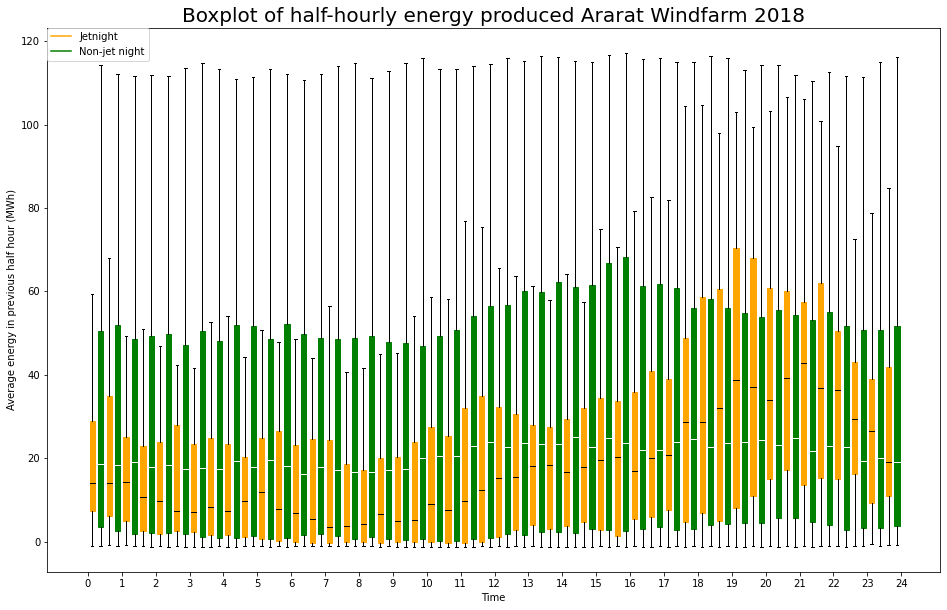

In [33]:
# Filter data using np.isnan
plt.figure(figsize = (16,10))
plt.boxplot(elecjn_filter, manage_ticks = False, showfliers = False, 
            positions = np.arange(0.25, 48.25, 1), widths = 0.3, patch_artist = True, 
            boxprops=dict(facecolor='orange', color='orange'),  medianprops=dict(color='black'))
plt.xlabel('Time')
plt.ylabel('Average energy in previous half hour (MWh)')
plt.title('Boxplot of half-hourly energy produced Coonooer Bridge Windfarm 2018 (Jetnights)')
plt.xticks(np.arange(0,50,2), labels = np.arange(0,25,1))

plt.boxplot(elecnonjn_filter, manage_ticks = False, showfliers = False, 
            positions = np.arange(0.75, 48.75, 1), widths = 0.3, patch_artist = True, 
            boxprops=dict(facecolor='green', color='green'),  medianprops=dict(color='white'))
plt.xlabel('Time')
plt.ylabel('Average energy in previous half hour (MWh)')
plt.title('Boxplot of half-hourly energy produced Ararat Windfarm 2018', fontsize = 20)

plt.xticks(np.arange(0,50,2), labels = np.arange(0,25,1))

hY, = plt.plot([0,1],'orange')
hG, = plt.plot([0,10],'green')
plt.legend((hY, hG),('Jetnight', 'Non-jet night'), loc = [0,0.94])
hY.set_visible(False)
hG.set_visible(False)

plt.savefig('Ararat boxplot')

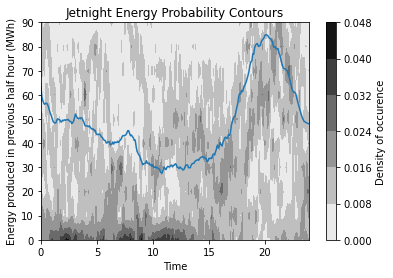

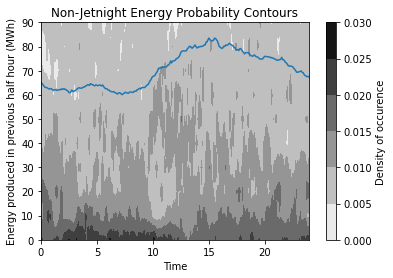

In [23]:
bins = 100 # Highest y-value (energy production)
histjn = np.empty([12*24,10])
histnonjn = np.empty([12*24,10])


for i in range(0,12*24): # produces number of values at each energy interval from 1-12
    histjn[i,:],_ = np.histogram(elecjn_2018np[:,i], bins = np.arange(0,bins+1,10), density = True)
    histnonjn[i,:],_ = np.histogram(elecnonjn_2018np[:,i], bins = np.arange(0,bins+1,10), density = True)

#hist.T
plt.contourf(np.arange(0,24,1/12), np.arange(0,bins,10), histjn.T, 5, cmap = 'binary') # histogram transposed so contour function reads it as columns rather than rows
plt.plot(hourly_mean_jetnight.iloc[:,2],hourly_mean_jetnight.iloc[:,1], label = 'Jetnight')
plt.colorbar(label = 'Density of occurence')
plt.title('Jetnight Energy Probability Contours')
plt.ylabel('Energy produced in previous half hour (MWh)')
plt.xlabel('Time')
plt.show()

plt.contourf(np.arange(0,24,1/12), np.arange(0,bins,10), histnonjn.T, 5, cmap = 'binary')
plt.plot(hourly_mean_nonjetnight.iloc[:,2],hourly_mean_nonjetnight.iloc[:,1], label = 'Non-Jetnight')
plt.colorbar(label = 'Density of occurence')
plt.title('Non-Jetnight Energy Probability Contours')
plt.ylabel('Energy produced in previous half hour (MWh)')
plt.xlabel('Time')
plt.show()


In [24]:
# Double checking contour graph makes sense
hour = 15*12
density, _ = np.histogram(elecnonjn_2018np[:,hour], bins = np.arange(0,100), density = False)
_, values = np.histogram(elecnonjn_2018np[:,hour], bins = np.arange(0,100), density = False)
print(density)
print(values)
print(stats.describe(elecnonjn_2018np[:,hour]))

[5 4 3 5 3 0 1 2 3 4 1 2 3 1 3 3 3 0 0 4 4 2 2 3 0 2 2 0 1 3 1 3 3 1 2 1 2
 2 4 4 2 2 0 3 2 3 1 1 2 2 4 1 1 0 1 0 1 0 3 1 2 2 0 1 2 1 1 1 1 1 0 1 2 0
 2 2 1 1 2 1 2 1 1 3 2 0 0 3 0 0 1 3 0 1 1 2 2 1 1]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
DescribeResult(nobs=320, minmax=(-2.5, 233.8), mean=83.51031221875, variance=5336.311390697857, skewness=0.5169192340297292, kurtosis=-1.1018111834768258)


In [25]:
# # Find percentage ramping events
# percent_ramp = np.empty(len(energy_2018)-1)
# energy_2018_np = energy_2018.to_numpy()
# for i in range(0,len(energy_2018)-1):
#     if energy_2018_np[i] == 0:
#         percent_ramp[i] = np.nan
#     else: percent_ramp[i] = ((energy_2018.iloc[i+1] - energy_2018.iloc[i]) / energy_2018.iloc[i]) * 100

# #percent_ramp = percent_ramp[~np.isnan(percent_ramp)]

In [26]:
# #jethour_true1 = np.delete(jethour_true, 0)
# jetnight_ramps = percent_ramp[jethour_true1]
# nonjetnight_ramps = percent_ramp[~jethour_true1]

In [27]:
# print('jethour_true length', len(jethour_true))
# print('percent_ramp length', len(percent_ramp))
# print('jethour_true1 length', len(jethour_true1))

In [28]:
# jetnightramp_proportion = np.empty(15)
# for index, i in enumerate(np.arange(0,150,10)):
#     ramp_all = percent_ramp >= i
#     ramp_jetnight = jetnight_ramps >= i
#     jetnightramp_proportion[index] = (ramp_jetnight.sum())*100/(ramp_all.sum())
    
# plt.bar(np.arange(0,150,10), abs(jetnightramp_proportion), width = 8)
# plt.title('Percentage of ramps of more than x% occuring on jetnights')
# plt.ylabel('Percentage occuring on jetnights')
# plt.xlabel('Change in power production from previous half hour (%)')

# jetnights_proportion = (jethour_true.sum()*100)/len(jethour_true)
# print('Percentage jetnights of all nights', jetnights_proportion, '%')

# plt.plot([0,150], [jetnights_proportion,jetnights_proportion], color = 'red', label = 'Jetnights % of all nights')
# plt.legend()
# plt.savefig('Percentage jetnights of all nights')

In [29]:
# plt.hist(abs(nonjetnight_ramps), bins = np.arange(0,140,20), density = False, label = 'Non Jetnight ramps')
# plt.title('Histogram of ramping events at Coonooer Bridge')
# plt.ylabel('Frequency')
# plt.xlabel('Absolute percentage change in energy production from previous half hour')

# plt.hist(abs(jetnight_ramps), bins = np.arange(0,140,20), density = False, alpha = 0.5, label = 'Jetnight ramps')
# plt.title('Histogram of ramping events at Coonooer Bridge')
# plt.ylabel('Probability')
# plt.xlabel('Absolute percentage change in energy production from previous half hour')

# plt.legend()
# plt.yscale('log')
# plt.savefig('Histogram of ramping events at Coonooer Bridge')

In [30]:
# # Checking for statistics regarding proportion of large rampings in jetnights vs non jetnights
# jetnight_20, _ = np.histogram(abs(jetnight_ramps), bins = np.arange(0,140,20)) # In 20% intervals
# nonjetnight_20, _ = np.histogram(abs(nonjetnight_ramps), bins = np.arange(0,140,20))
# n = 2
# jetnight_20[n:].sum()/(jetnight_20[n:].sum() + nonjetnight_20[n:].sum())


### 2 sample statistical tests 

In [31]:
print(elecjn_2018np.shape)
print(elecnonjn_2018np.shape)

(45, 288)
(320, 288)


In [32]:
from statsmodels.stats.weightstats import ztest as ztest

z_score = np.empty(12*24)
p_value = np.empty(12*24)
for i in range(0,12*24):
    filtjn, filtnonjn = ~np.isnan(elecjn_2018np[:,i]), ~np.isnan(elecnonjn_2018np[:,i]) # removes nans before passing through significance test
    z_score[i], p_value[i] = ztest(elecjn_2018np[:,i][filtjn], elecnonjn_2018np[:,i][filtnonjn], value = 0)


significant = p_value < 0.05
significant

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

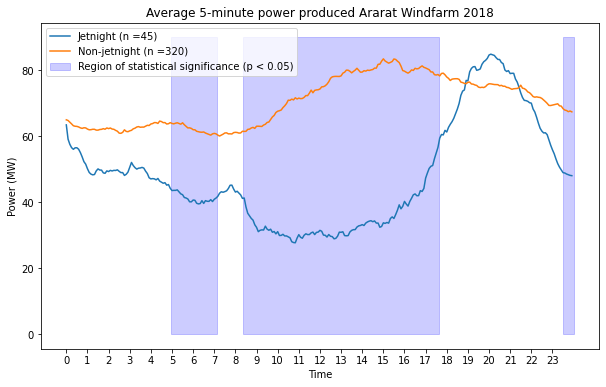

In [33]:
plt.figure(figsize = [10,6])
plt.plot(hourly_mean_jetnight.iloc[:,2],hourly_mean_jetnight.iloc[:,1], 
         label = 'Jetnight (n ='+str(jetnight_true.sum().data)+')')
plt.plot(hourly_mean_nonjetnight.iloc[:,2],hourly_mean_nonjetnight.iloc[:,1], 
         label = 'Non-jetnight (n ='+str(365-jetnight_true.sum().data)+')')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.title('Average 5-minute power produced Ararat Windfarm 2018')
plt.xticks(np.arange(0,24))
plt.fill_between(np.linspace(0,24,12*24),0,90, where = significant,
                 facecolor="blue", # The fill color
                 color='blue',       # The outline color
                 alpha=0.2, label = 'Region of statistical significance (p < 0.05)')   

plt.legend()
plt.savefig('Ararat power jetnights (' + str(gridpoints**2) + 'gridpoints)')

### Price Data

In [62]:
# On a jetnight an array is created so that every half hour timestep within a jetnight is defined at 'True' and
# 'False' otherwise
jethour_true = np.empty(365*48)
for day in range(0,365):
    daystart = day*48 #Offset by 12 hours (24 half hours) to start at 12pm instead of midnight
    dayend = (day*48)+48 
    for hour in range(daystart,dayend):
        jethour_true[hour] = jetnight_true[day]
jethour_true.sum()
#jethour_true = np.delete(jethour_true,[-1])
jethour_true = np.array(jethour_true, dtype = bool)

In [63]:
price_data = pd.read_csv('Downloads/VIC_2018.csv')
price_data.iloc[:,0] = pd.to_datetime(price_data.iloc[:,0], infer_datetime_format = True)
price = price_data.set_index('SETTLEMENTDATE').iloc[:,2]
energy_2018 = energy_2018.reindex(pd.date_range(start=datetime(2017,12,31,6,0),end = datetime(2018,12,31,5,30,0), 
                    freq = '5Min'))

In [64]:
price_reindexed = price.reindex(energy_2018.index).dropna()
energy_reindexed = energy_2018.reindex(price.index).dropna()
revenue = price_reindexed * energy_reindexed.iloc[:,0] # $/MWh * MWh
revenue = revenue.to_frame()
revenue['time'] = revenue.index
revenue['hour'] = revenue.time.dt.hour
revenue['minute'] = revenue.time.dt.minute
jetnight_revenue = revenue[jethour_true[37:]] #remove 6:00 31-12 to 00:00 1-1 (37 half hours)
nonjetnight_revenue = revenue[~jethour_true[37:]]


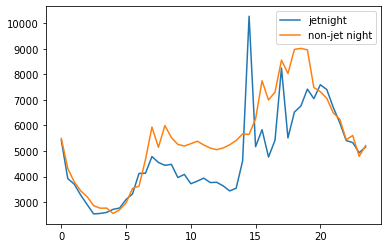

In [65]:
jetnight_hourly_revenue = jetnight_revenue.groupby(['hour','minute']).mean()
nonjetnight_hourly_revenue = nonjetnight_revenue.groupby(['hour','minute']).mean()
plt.plot(np.arange(0,24,0.5), jetnight_hourly_revenue, label = 'jetnight')
plt.plot(np.arange(0,24,0.5), nonjetnight_hourly_revenue, label = 'non-jet night')
plt.legend()